# 03_MLP-Growth-Prune-Synapses

Decision to grow or prune. For $d \sim \text{Bern}(\epsilon_i)$. We set a priori the number of training cycles $n$. So we set $\epsilon_i = \epsilon_{i - 1} - 1/n$

$$A_i = \begin{cases}
\text{RandExpand}(A_{i-1}) & d=0 \\
\text{ActivityPrune}(A_{i-1}) & d=1 \\
\end{cases}$$

Hypter parameter $\gamma$ to control grow and pruning.
$$|\text{RandExpand}(A_{i})| = |A_{i - 1}| + \gamma$$
$$|\text{ActivityPrune}(A_{i})| = |A_{i - 1}| - \gamma$$

The idea is to create an tensor attribute for the $D$ matrix. In the original text, Stothers describes using $D$ such that 1 refers to a dead neuron, and 0 for an alive one. I will change this tensor to $A$ for active. This way, 1 is alive and 0 is dead. Thus, the new forward step is:

$$y = a \cdot w \cdot x + b$$
$$Y = (A * W)X + \beta$$

Where $*$ is element wise multiplication. If $a_{i,j}$ is 0, then $dL/dw = a * x = 0 * x = 0$, so no updates will be made.

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from src.simple_pruning_growth_model import PruneGrowNetwork
from src.training_testing_loop import full_train, save_model_attr
from src.load_MNIST import load_MNIST
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_dataloader, val_dataloader, test_dataloader = load_MNIST(root='./data', subset_frac=0.1, batch_size=64)

**TODO**: should I normalize the data?

In [4]:
model = PruneGrowNetwork(gamma=0.1, init_density=0.5, num_training_iter=100)

train_losses_epoch, val_losses_epoch, test_df = full_train(
    model, train_dataloader, val_dataloader, test_dataloader,
    learning_rate = 1e-2, 
    plot=False, verbose=False
)

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]

done!


In [10]:
model_pth = './data/03.grow_prune.model.state_dict.pth'
model_pth

'./data/03.grow_prune.model.state_dict.pth'

In [11]:
torch.save(model.state_dict(), model_pth)

In [24]:
model_attr_pth = './data/03.grow_prune.model.attr.pkl'

In [23]:
save_model_attr(model, './data/03.grow_prune.model.attr.pkl')

In [26]:
import pickle

with open(model_attr_pth, 'rb') as fp:
    model_attr = pickle.load(fp)

In [12]:
training_losses_df = pd.DataFrame(train_losses_epoch).T
training_losses_df.columns.name = 'batch'
training_losses_df.index.name = 'epoch'

val_losses_df = pd.DataFrame(val_losses_epoch).T
val_losses_df.columns.name = 'batch'
val_losses_df.index.name = 'epoch'

stack_training_losses_df = training_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_training_losses_df.index = stack_training_losses_df['epoch'].astype(str) + '-' + stack_training_losses_df['batch'].astype(str)
stack_training_losses_df.index.name = 'index'
stack_val_losses_df = val_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_val_losses_df.index = stack_val_losses_df['epoch'].astype(str) + '-' + stack_val_losses_df['batch'].astype(str)
stack_val_losses_df.index.name = 'index'

In [14]:
training_losses_fn = './data/03.training_losses.tsv'
val_losses_fn = './data/03.val_losses.tsv'

training_losses_df.to_csv(training_losses_fn, sep='\t')
val_losses_df.to_csv(val_losses_fn, sep='\t')

# Plot performance

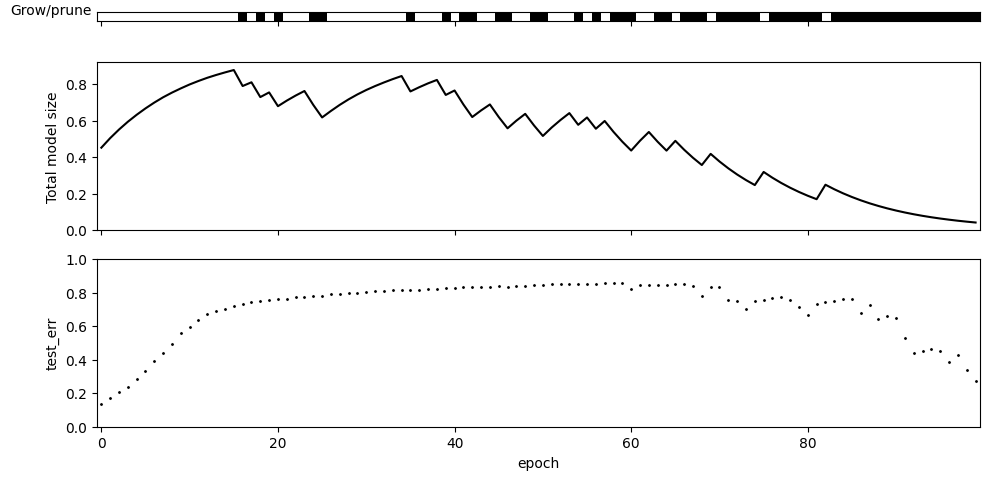

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(model_attr['grow_prune_history']).reshape(1, -1), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(np.array(model_attr['synapse_count_history']) / model.total_size, c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()

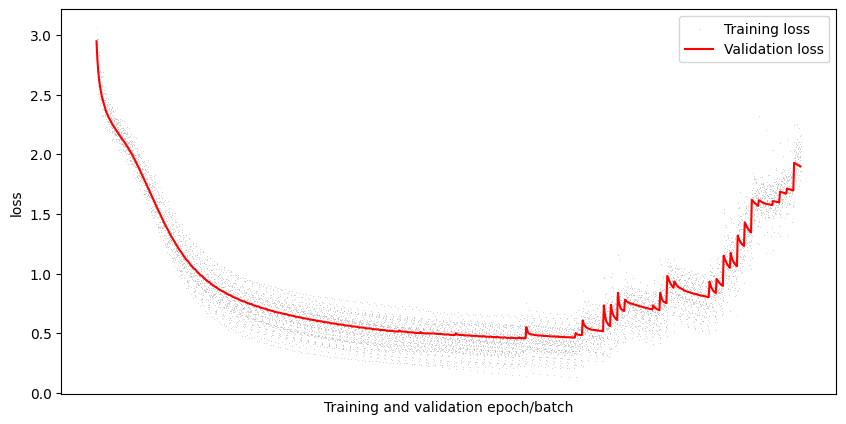

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=0.5, c='gray', s=0.5)
sns.lineplot(stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red')
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

**TODO** Regularization or other way to determine when to stop pruning?
- Seems like we see increase loss in training and validation too